<a href="https://colab.research.google.com/github/kuo8129/GenAI/blob/main/20250325HW_%E6%89%93%E9%80%A0%E8%87%AA%E5%B7%B1%E7%9A%84%E5%B0%8D%E8%A9%B1%E6%A9%9F%E5%99%A8%E4%BA%BA/20250325HW_%E6%89%93%E9%80%A0%E8%87%AA%E5%B7%B1%E7%9A%84%E5%B0%8D%E8%A9%B1%E6%A9%9F%E5%99%A8%E4%BA%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 匯入套件

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install openai
!pip install requests
!pip install gradio

# 環境設置
* 讀入 Groq 與 中央氣象署 的 API key
* 使用 OpenAI 的 API 來打造對話機器人

In [3]:
import os
from google.colab import userdata
from openai import OpenAI

In [4]:
# 使用 Groq 的 API key
groq_api_key = userdata.get('Groq')
model = "llama3-70b-8192"
base_url = "https://api.groq.com/openai/v1"

In [5]:
# 使用 中央氣象署 的 API key
weather_api_key = userdata.get('Weather')
weather_url = "https://opendata.cwa.gov.tw/api/v1/rest/datastore/F-C0032-001"

In [6]:
# 使用 OpenAI 的 API
os.environ['OPENAI_API_KEY'] = groq_api_key

In [7]:
# 初始化對話機器人
client = OpenAI(
    base_url = base_url
)

# 用 Gradio 打造對話機器人
* 根據輸入的地點至中央氣象署獲取天氣資訊
* 依照當前時間、天氣資訊播報氣象

In [8]:
from datetime import datetime, timezone, timedelta
import requests
import re
import gradio as gr

In [9]:
title = "🌥 AI 氣象台 🌥"
system = '''
    你是一位資深的氣象主播，觀眾可以指定一個台灣的縣市名稱，讓你進行氣象播報，
    請你根據收到的資訊，用臺灣習慣的"繁體中文"不要用其他國家的語言，
    以"約250字"、"輕鬆的口吻"向觀眾播報氣象並提供建議。
    '''
description = "各位觀眾大家好，本節目由AI機器人主持，請輸入您想查詢的臺灣縣市名稱，AI主播即為您播報最新的氣象資訊🌡"

In [10]:
messages = [{"role":"system",
             "content":system}]

In [11]:
# 提取當前時間
def current_time():
    taiwan_timezone = timezone(timedelta(hours=+8))
    now = datetime.now(taiwan_timezone).strftime("%Y-%m-%d %H:%M")
    return now

In [12]:
# 定義台灣縣市名稱
Locations = [
    "臺北市", "新北市", "基隆市", "桃園市", "新竹市", "新竹縣",
    "苗栗縣", "臺中市", "彰化縣", "南投縣", "雲林縣", "嘉義市",
    "嘉義縣", "臺南市", "高雄市", "屏東縣", "宜蘭縣", "花蓮縣",
    "臺東縣", "澎湖縣", "金門縣", "連江縣"
]

In [13]:
# 檢查輸入的地名是否為有效名稱
def check_location(message):
    corrected_message = re.sub("台", "臺", message) # 替換「台」為「臺」
    for location in Locations:
        if re.search(corrected_message, location): # 檢查是否為有效名稱
            return location
    return None

In [14]:
# 向中央氣象局查詢指定地區的天氣資料
def get_weather_data(location):
    params = {
        "Authorization": weather_api_key,
        "format": "JSON",
        "locationName": location
    }

    try:
        response = requests.get(weather_url, params=params)
        response.raise_for_status()
        data = response.json()

        if "records" in data and "location" in data["records"]:
            return data
        else:
            return None

    except requests.exceptions.RequestException as e:
        print(f"API 請求錯誤: {e}")
        return None

In [15]:
# 提取天氣資訊
def extract_weather_info(data):
    location_data = data['records']['location'][0]
    weather_elements = location_data['weatherElement']
    weather_info = {
        'location': location_data['locationName'],
    }

    for element in weather_elements:
        element_name = element['elementName']
        for time in element['time']:
            parameter = time['parameter']
            parameter_str = parameter['parameterName']
            if 'parameterUnit' in parameter:
                parameter_str += f" {parameter['parameterUnit']}"

            weather_info[element_name] = parameter_str

    return weather_info

In [16]:
# 設置氣象對話機器人
def mychatbot(prompt):
    now = current_time()
    location = check_location(prompt)

    if location:

        weather_data = get_weather_data(location)

        if not weather_data:
            user_message = f" {now} 目前無法取得 {location} 的天氣資料"
        else:
            weather_info = extract_weather_info(weather_data)
            user_message = f"請問現在 {now} {location} 的天氣如何？天氣資訊如下：\n" + \
                             f"天氣狀況: {weather_info.get('Wx', '未知')}\n" + \
                             f"溫度: {weather_info.get('MinT', '未知')}°C - {weather_info.get('MaxT', '未知')}°C \n" + \
                             f"降雨機率: {weather_info.get('PoP', '未知')}%\n" + \
                             f"體感: {weather_info.get('CI', '未知')}"
    else:
        user_message = f" {prompt} 不是有效的臺灣縣市名稱"

    messages.append({"role": "user", "content": user_message})
    chat_completion = client.chat.completions.create(
        messages = messages,
        model = model,
    )
    reply = chat_completion.choices[0].message.content
    return reply

In [ ]:
iface = gr.Interface(mychatbot,
                     inputs = "text",
                     outputs = "text",
                     title = title,
                     description = description)
iface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c0cbc64111e4a97031.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


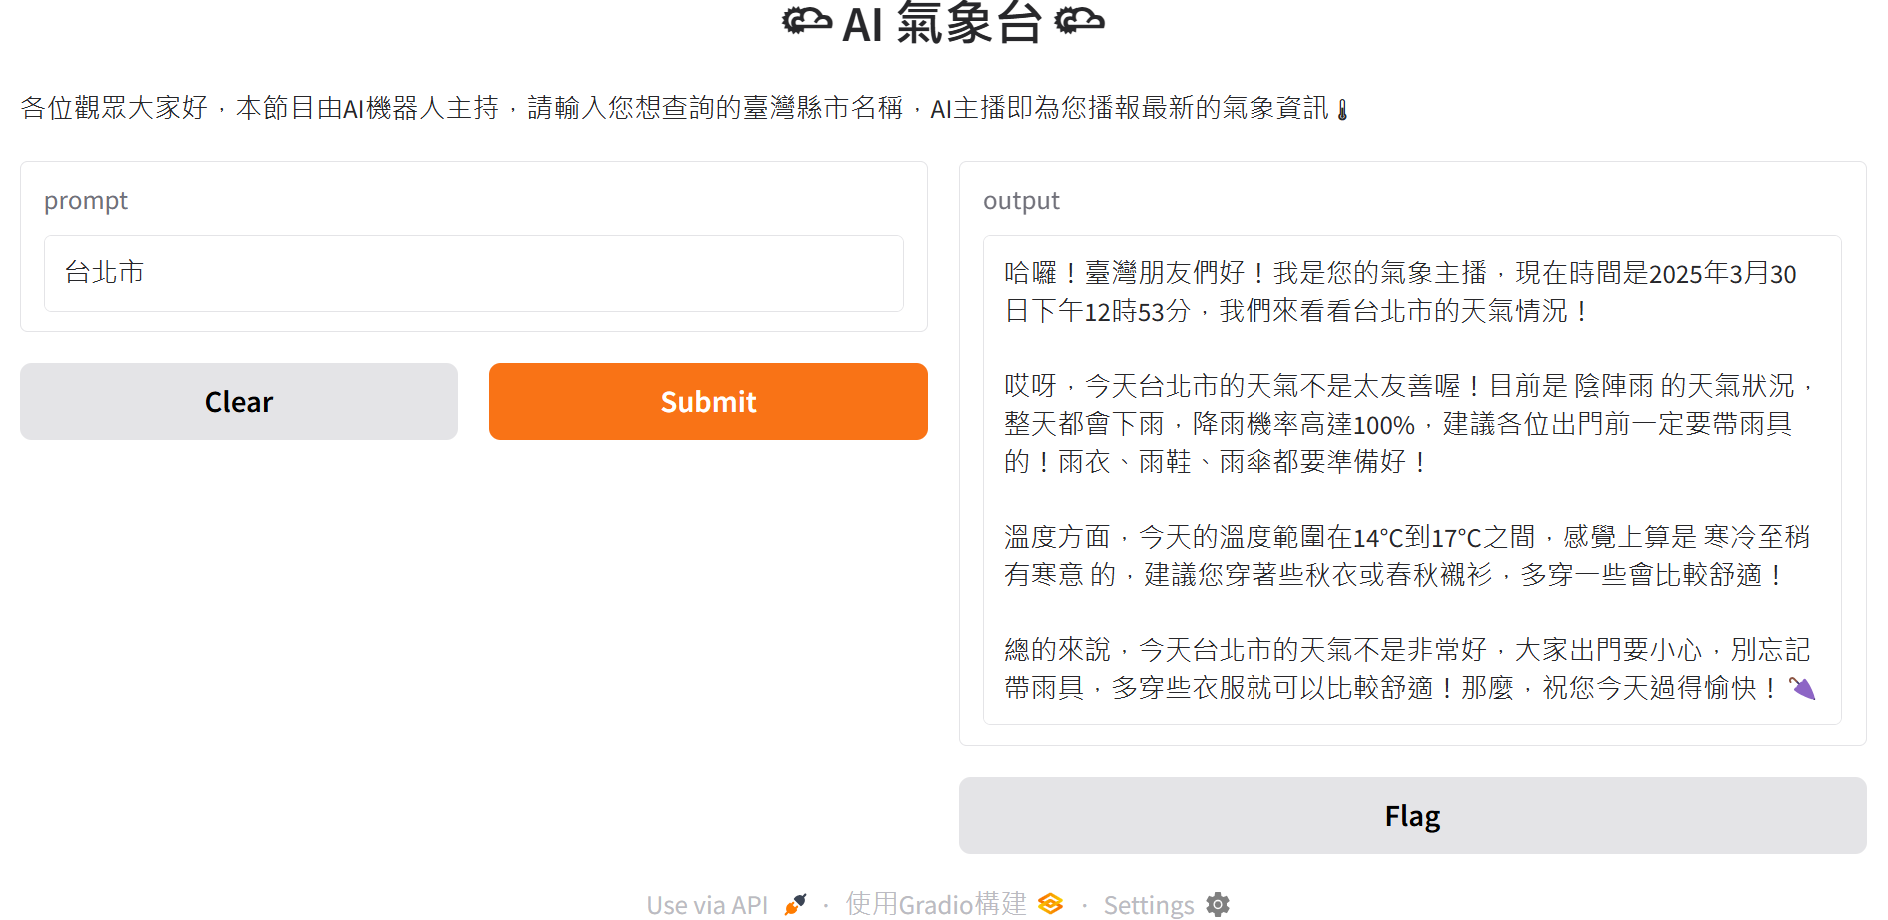